<div style="text-align: center;">
    <h1>Versão em andamento</h1>
</div>

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import graphviz
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE 


In [5]:
df = pd.read_csv('C:/Users/wesle/machine-learning-tecnicas/Dataset/depression_data.csv')

df.drop('id', axis = 1, inplace = True)

In [6]:
df.isnull().sum()

school_year             0
age                     0
gender                  0
bmi                     0
who_bmi                 0
phq_score               0
depression_severity     4
depressiveness          3
suicidal                1
depression_diagnosis    1
depression_treatment    4
gad_score               0
anxiety_severity        0
anxiousness             6
anxiety_diagnosis       4
anxiety_treatment       2
epworth_score           8
sleepiness              8
dtype: int64

In [7]:
print('Antes da remoção de missings:\n', df['anxiety_diagnosis'].value_counts(),'\n')
print('Antes da remoção de missings:\n', df['depression_diagnosis'].value_counts())

Antes da remoção de missings:
 anxiety_diagnosis
False    718
True      61
Name: count, dtype: int64 

Antes da remoção de missings:
 depression_diagnosis
False    716
True      66
Name: count, dtype: int64


In [8]:
df.dropna(inplace = True) #removendo valores missing, 18 observações foram removidos (783-165)

In [9]:
print('Depois da remoção de missings:\n', df['anxiety_diagnosis'].value_counts(),'\n')
print('Depois da remoção de missings:\n', df['depression_diagnosis'].value_counts())

Depois da remoção de missings:
 anxiety_diagnosis
False    704
True      61
Name: count, dtype: int64 

Depois da remoção de missings:
 depression_diagnosis
False    699
True      66
Name: count, dtype: int64


In [10]:
df = df[df['who_bmi'] != 'Not Availble'] #a partir daqui, not availble não aparece mais, pega todos os elementos menos ele, isso significa que mais 8 observações foram removidas

In [11]:
df.shape

(757, 18)

## Transformando dados categórico para numérico

In [13]:
#gender
df['gender'] = df['gender'].map({'female':0,'male':1})

#who_bmi
df['who_bmi'] = df['who_bmi'].map( {
    "Underweight": 0,
    "Normal": 1,
    "Overweight": 2,
    "Class I Obesity": 3,
    "Class II Obesity": 4,
    "Class III Obesity": 5,
})

#depression_severity
df['depression_severity'] = df['depression_severity'].map({
    "none": 0,
    "None-minimal": 1,
    "Mild":2,
    "Moderate": 3,
    "Moderately severe": 4,
    "Severe": 5,
})

#anxiety_severity
df['anxiety_severity'] = df['anxiety_severity'].replace(0, 'none')

df['anxiety_severity'] = df['anxiety_severity'].replace({
    'none': 0,
    "None-minimal": 1,
    "Mild": 2,
    "Moderate": 3,
    "Severe": 4
})


C:\Users\wesle\AppData\Local\Temp\ipykernel_9052\114210172.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['anxiety_severity'] = df['anxiety_severity'].replace({


## O restante dos atributos categóricos, False e True para numéricos

In [15]:
colunas = ['depressiveness','suicidal', 'depression_treatment', 'anxiousness', 'anxiety_diagnosis', 'anxiety_treatment', 'sleepiness', 'depression_diagnosis']

for coluna in colunas:
    df[coluna] = df[coluna].astype(int)

In [16]:
df

,school_year,age,gender,bmi,who_bmi,phq_score,depression_severity,depressiveness,suicidal,depression_diagnosis,depression_treatment,gad_score,anxiety_severity,anxiousness,anxiety_diagnosis,anxiety_treatment,epworth_score,sleepiness
0,1,19,1,33.333333,3,9,2,0,0,0,0,11,3,1,0,0,7.0,0
1,1,18,1,19.841270,1,8,2,0,0,0,0,5,2,0,0,0,14.0,1
2,1,19,1,25.102391,2,8,2,0,0,0,0,6,2,0,0,0,6.0,0
3,1,18,0,23.738662,1,19,4,1,1,0,0,15,4,1,0,0,11.0,1
4,1,18,1,25.617284,2,6,2,0,0,0,0,14,3,1,0,0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,4,24,0,21.096191,1,6,2,0,0,0,0,1,1,0,0,0,3.0,0
779,4,22,1,25.308642,2,4,1,0,0,0,0,6,2,0,0,0,3.0,0
780,4,22,1,22.720438,1,2,1,0,0,0,0,5,2,0,0,0,4.0,0
781,4,22,0,23.033168,1,17,4,1,0,0,0,19,4,1,0,0,15.0,1


## Separando as características (X) e rótulos (y)

In [18]:
X = df.drop(columns=['depression_diagnosis'])
y = df['depression_diagnosis']

## Visualizando o desbalanceamanento entre as classes

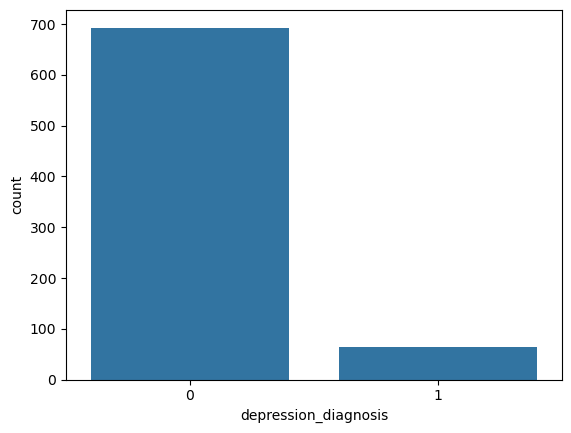

In [20]:
ax = sns.countplot(x = "depression_diagnosis", data = df)

## Aplicando SMOTE resample

In [22]:
#resampling_strategy=0.5, padrão = 1
smt = SMOTE()

In [23]:
# Ajustando os dados usando fit_resample 
X_resampled, y_resampled = smt.fit_resample(X, y)

### Visualizando o balanceamento 

In [25]:
print("Distribuição antes do balanceamento:") 
print(df['depression_diagnosis'].value_counts())

Distribuição antes do balanceamento:
depression_diagnosis
0    693
1     64
Name: count, dtype: int64


In [26]:
df_resampled = pd.DataFrame(X_resampled, columns=X.columns) 
df_resampled['depression_diagnosis'] = y_resampled

In [27]:
print("\nDistribuição depois do balanceamento:") 
print(df_resampled['depression_diagnosis'].value_counts())


Distribuição depois do balanceamento:
depression_diagnosis
0    693
1    693
Name: count, dtype: int64


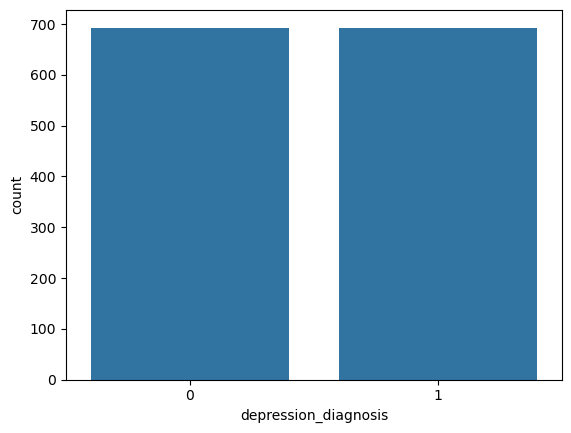

In [28]:
ax = sns.countplot(x = "depression_diagnosis", data = df_resampled)

In [29]:
#Quantidade de observações do df reamostrado
df_resampled.shape

(1386, 18)

# Decision Tree
Implementação do modelo

In [31]:
#Instanciando o modelo
decision_tree = DecisionTreeClassifier(random_state = 42)

### Sem resample

In [33]:
#dividindo o dataset em treino e teste com todas as características (holdout)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

decision_tree.fit(X_train, y_train)

y_pred_all_features = decision_tree.predict(X_test)

#avaliando o modelo com o cross-validation
cv_scores = cross_val_score(decision_tree, X_train, y_train, cv = 10, scoring='accuracy')

print('Relatório do modelo sem resample com todas as características\n\n', classification_report(y_test, y_pred_all_features))
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

Relatório do modelo sem resample com todas as características

               precision    recall  f1-score   support

           0       0.98      0.95      0.96       218
           1       0.31      0.50      0.38        10

    accuracy                           0.93       228
   macro avg       0.64      0.72      0.67       228
weighted avg       0.95      0.93      0.94       228

Acurácia média da validação cruzada: 88.85%
Desvio padrão da acurácia: 3.51%


### Com resample

In [35]:
#dividindo o dataset em treino e teste com todas as características (holdout) e reamostrado
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state = 42)

decision_tree.fit(X_train, y_train)

y_pred_all_features_resampled = decision_tree.predict(X_test)

#avaliando o modelo com o cross-validation
cv_scores = cross_val_score(decision_tree, X_train, y_train, cv = 10, scoring='accuracy')

print('Relatório do modelo com resample com todas as características\n\n', classification_report(y_test, y_pred_all_features_resampled))
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

Relatório do modelo com resample com todas as características

               precision    recall  f1-score   support

           0       0.96      0.85      0.90       204
           1       0.87      0.96      0.91       212

    accuracy                           0.91       416
   macro avg       0.91      0.91      0.91       416
weighted avg       0.91      0.91      0.91       416

Acurácia média da validação cruzada: 89.79%
Desvio padrão da acurácia: 3.27%


### Importância de atributos

Nível de importância das características:
                 Feature  Importance
9   depression_treatment    0.230287
15         epworth_score    0.132626
10             gad_score    0.121423
3                    bmi    0.111598
5              phq_score    0.104155
2                 gender    0.081487
0            school_year    0.051718
1                    age    0.038486
6    depression_severity    0.032882
4                who_bmi    0.022605
13     anxiety_diagnosis    0.018696
7         depressiveness    0.016750
16            sleepiness    0.012432
11      anxiety_severity    0.009511
12           anxiousness    0.005891
8               suicidal    0.005530
14     anxiety_treatment    0.003923


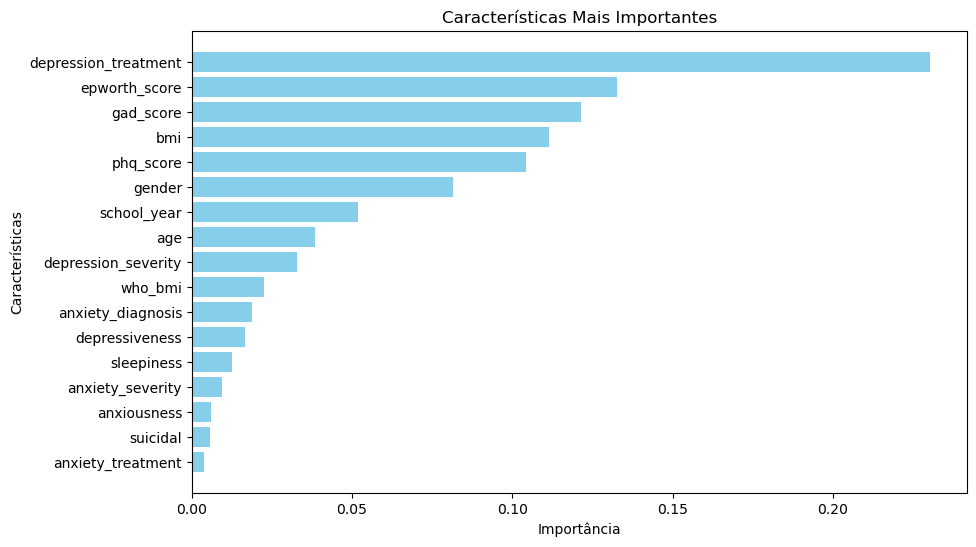

In [37]:
feature_importances = decision_tree.feature_importances_

# Organizando em um DataFrame para melhor visualização
features_df = pd.DataFrame({
    'Feature': X.columns,  
    'Importance': feature_importances
})

# Ordenando pela importância em ordem decrescente
features_df = features_df.sort_values(by='Importance', ascending=False)

# Exibindo as importantes segundo o critério defaul Gini do Random Forest
print("Nível de importância das características:")
print(features_df)

plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.ylabel('Características')
plt.title('Características Mais Importantes')
plt.gca().invert_yaxis()  
plt.show()

### Selecionando os melhores atributos

In [39]:
selector = SelectKBest(score_func = f_classif, k=5)
X_selected = selector.fit_transform(X, y)
view_features = X.columns[selector.get_support()]

#transformando as características selecionadas de ndarray para dataframe
X_selected_df = pd.DataFrame(X_selected, columns=view_features) 
print("Características selecionadas:\n", view_features)

Características selecionadas:
 Index(['depression_severity', 'depressiveness', 'depression_treatment',
       'anxiety_diagnosis', 'anxiety_treatment'],
      dtype='object')


In [40]:
#novo SMOTE para as características selecionadas
X_resampled_selected, y_resampled_selected = smt.fit_resample(X_selected, y)
print(f"Distribuição das classes após SMOTE: {y_resampled_selected.value_counts()}")

Distribuição das classes após SMOTE: depression_diagnosis
0    693
1    693
Name: count, dtype: int64


In [41]:
#divisão de treino e teste com os melhores atributos (holdout)
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_resampled_selected, y_resampled_selected, test_size=0.3, random_state = 42)

decision_tree.fit(X_train_selected, y_train_selected)

y_pred_selected_features = decision_tree.predict( X_test_selected)

#avaliando o modelo com o cross-validation
cv_scores = cross_val_score(decision_tree, X_train_selected,  y_train_selected, cv = 10, scoring='accuracy')

print('Relatório do modelo com as melhores características selecionadas\n\n', classification_report(y_test_selected, y_pred_selected_features ))
print(f"Acurácia média da validação cruzada: {cv_scores.mean() * 100:.2f}%")
print(f"Desvio padrão da acurácia: {cv_scores.std() * 100:.2f}%")

Relatório do modelo com as melhores características selecionadas

               precision    recall  f1-score   support

           0       0.86      0.97      0.91       204
           1       0.97      0.85      0.90       212

    accuracy                           0.91       416
   macro avg       0.91      0.91      0.91       416
weighted avg       0.92      0.91      0.91       416

Acurácia média da validação cruzada: 93.30%
Desvio padrão da acurácia: 2.27%


### visualizando árvore criada

In [43]:
dot_data = export_graphviz(decision_tree, out_file = None, feature_names = X_selected_df.columns, 
                           class_names = ['0 - sem depressão',
                                          '1 - com depressão'],filled = True, rounded = True, special_characters = True)

graph = graphviz.Source(dot_data)
graph

#exportando para pdf

graph.render("tree_output_5_feature_selected")

'tree_output_5_feature_selected.pdf'

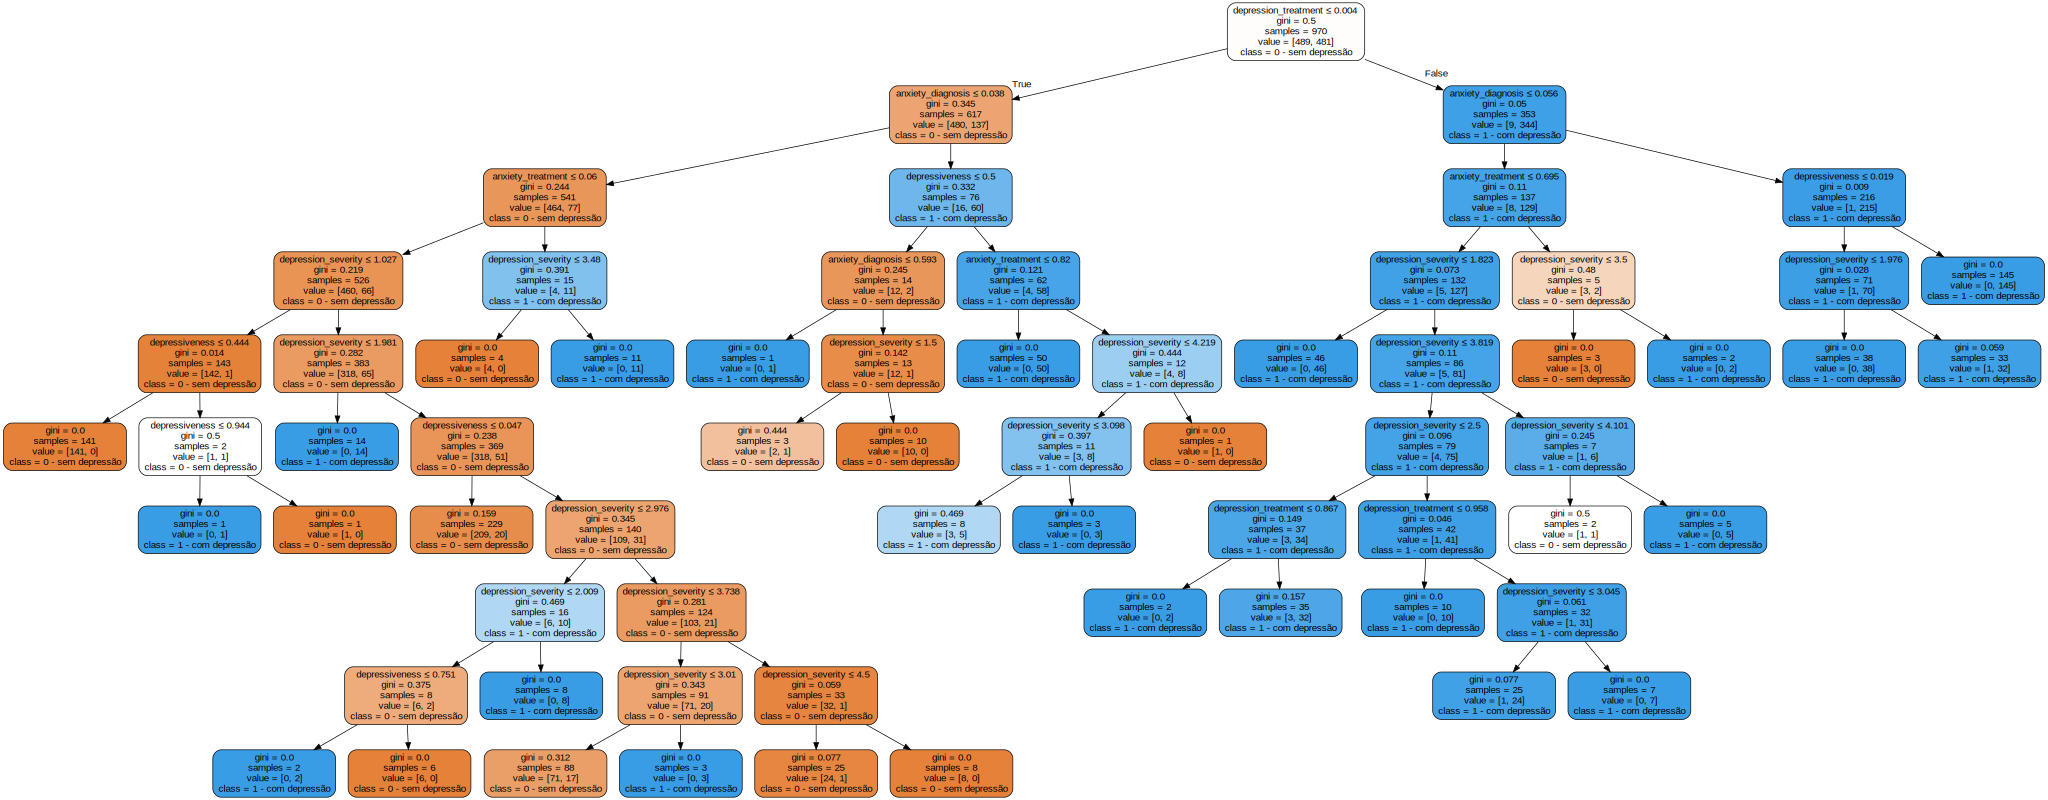

In [44]:
graph

In [45]:
dot_data = export_graphviz(decision_tree, out_file = None, feature_names = X_selected_df.columns, 
                           class_names = ['0 - sem depressão',
                                          '1 - com depressão'],filled = True, rounded = True, special_characters = True, max_depth=3)

graph = graphviz.Source(dot_data)

#exportando para pdf

graph.render("tree_output_5_feature_selected_max_depth_3")

'tree_output_5_feature_selected_max_depth_3.pdf'